In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import transforms, datasets
from torch.utils.data import DataLoader
import torch.nn.functional as F

import matplotlib.pyplot as plt
import numpy as np
import time

In [2]:
# Load CIFAR-10 data

train_set = datasets.CIFAR10('cifar',
            train=True, download=True,
            transform=transforms.Compose([
                transforms.Resize((32, 32)),
                transforms.ToTensor()
            ]))
train_loader = DataLoader(train_set, batch_size=64, shuffle=True)


test_set = datasets.CIFAR10('cifar', train=False,
                          transform = transforms.Compose([
                              transforms.Resize((32, 32)),
                              transforms.ToTensor()
                          ]))
test_loader = DataLoader(test_set, batch_size=64, shuffle=True)

100%|██████████| 170M/170M [00:04<00:00, 34.7MB/s]


Extracting cifar/cifar-10-python.tar.gz to cifar


In [3]:
print(f"Shape of train data: {train_loader.dataset.data.shape}")
print(f"Shape of test data: {test_loader.dataset.data.shape}")

Shape of train data: (50000, 32, 32, 3)
Shape of test data: (10000, 32, 32, 3)


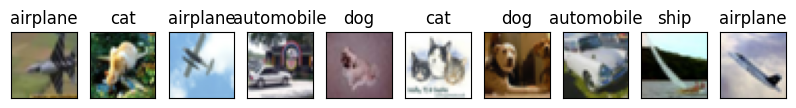

In [4]:
def visualize(dataset):
    dataiter = iter(dataset)
    images, labels = next(dataiter)
    images = images.numpy()
    fig = plt.figure(figsize=(10, 10))
    for idx in np.arange(10):
        ax = fig.add_subplot(2, 10, idx+1, xticks=[], yticks=[])
        plt.imshow(np.transpose(images[idx], (1,2,0)))
        ax.set_title(train_set.classes[labels[idx]])

visualize(train_loader)

In [5]:

# Определение базового блока ResNet
class ResBlock(nn.Module):
    expansion = 1  # Коэффициент расширения для выходных каналов

    def __init__(self, in_planes, planes, stride=1):
        super(ResBlock, self).__init__()
        # Первый сверточный слой
        self.conv0 = nn.Conv2d(
            in_planes, planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn0 = nn.BatchNorm2d(planes)  # Нормализация после первого сверточного слоя

        # Второй сверточный слой
        self.conv1 = nn.Conv2d(planes, planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(planes)  # Нормализация после второго сверточного слоя

        # Определение "shortcut" (прямого соединения)
        self.shortcut = nn.Sequential()
        if stride != 1 or in_planes != self.expansion * planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, self.expansion * planes,
                          kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.expansion * planes)
            )

    def forward(self, x):
        # Первый слой
        out = self.conv0(x)
        out = self.bn0(out)
        out = F.relu(out)  # Применение ReLU к выходу первого сверточного слоя

        # Второй слой
        out = self.conv1(out)
        out = self.bn1(out)  # Нормализация и выход второго сверточного слоя

        out += self.shortcut(x)  # Добавление прямого соединения
        out = F.relu(out)  # Применение ReLU к итоговому выходу
        return out


# ResNet34
class ResNet(nn.Module):
    def __init__(self, block=ResBlock, num_blocks=[3, 4, 6, 3], num_classes=10):
        super(ResNet, self).__init__()
        self.in_planes = 64  # Начальное количество каналов

        # Первый сверточный слой и нормализация
        self.conv1 = nn.Conv2d(3, 64, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(64)

        # Слои ResNet с использованием базового блока
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # Полносвязный слой для классификации
        self.linear = nn.Linear(512 * block.expansion, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks - 1)  # Определение шагов для слоев
        layers = []

        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))  # Добавление блока в слой
            self.in_planes = planes * block.expansion  # Обновление количества входных каналов

        return nn.Sequential(*layers)  # Возврат последовательности слоев

    def forward(self, x):
        out = self.conv1(x)
        out = self.bn1(out)
        out = F.relu(out)  # Прямой проход через первый слой

        out = self.layer1(out)  # 1
        out = self.layer2(out)  # 2
        out = self.layer3(out)  # 3
        out = self.layer4(out)  # 4

        out = F.avg_pool2d(out, 4)  # Усредняющее пулингование
        out = out.view(out.size(0), -1)  # Изменение формы тензора для полносвязного слоя
        out = self.linear(out)  # Проход через полносвязный слой

        return out

In [6]:
def get_time():
    t = time.localtime()
    # Время по МСК
    return f"{t.tm_hour+3}:{time.strftime('%M:%S', t)}"

# Train
def train(model, train_loader, criterion, optimizer, num_epochs, device):
    model.to(device)  # Перемещение модели на устройство (CPU или GPU)
    loss_arr = []  # Список для хранения значений потерь

    print('Начало обучения')

    for epoch in range(num_epochs):
        start_time = time.time()

        model.train()

        running_loss = 0.0
        accuracy_list = []

        correct_predictions = 0

        for inputs, labels in train_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            optimizer.zero_grad()  # Обнуление градиентов перед обратным проходом

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            loss.backward()  # Обратное распространение ошибки

            optimizer.step()  # Обновление параметров модели

            running_loss += loss.item()

            _, predictions = torch.max(outputs.data, dim=1)
            correct_predictions += (predictions == labels).sum().item()

        loss = running_loss / len(train_loader)
        loss_arr.append(loss)

        accuracy = correct_predictions / len(train_loader.dataset)
        accuracy_list.append(accuracy)

        print(f"[{get_time()}] \t Epoch: {epoch + 1}/{num_epochs} \t accuracy: {accuracy:.4f} \t loss: {loss:.4f} \t time: {(time.time() - start_time):.2f} s.")

    return loss_arr, accuracy_list

# Test
def test(model, test_loader, criterion, device):
    model.eval()
    test_loss = 0.0
    all_predictions = 0
    correct_predictions = 0

    with torch.no_grad():
        for inputs, labels in test_loader:
            inputs, labels = inputs.to(device), labels.to(device)

            outputs = model(inputs)
            loss = criterion(outputs, labels)
            test_loss += loss.item()

            _, predictions = torch.max(outputs.data, dim=1)
            all_predictions += labels.size(0)
            correct_predictions += (predictions == labels).sum().item()

    test_loss /= len(test_loader)
    test_accuracy = correct_predictions / all_predictions

    print(f'Test Loss: {test_loss:.4f}, Test Accuracy: {test_accuracy:.4f}')

In [7]:
# Настройка и обучение модели
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print('Устройство:', device)

modelRes = ResNet()  # Инициализация ResNet34
criterion = nn.CrossEntropyLoss()  # Критерий потерь
optimizer = optim.SGD(modelRes.parameters(), lr=0.02,
                      momentum=0.9, weight_decay=5e-4)

# Обучение
loss_list, accuracy_list = train(modelRes, train_loader, criterion, optimizer, num_epochs=15, device=device)

# Тест
print('Начало тестирования')
test(modelRes, test_loader, criterion, device)

Устройство: cuda
Начало обучения
[21:03:22] 	 Epoch: 1/15 	 accuracy: 0.4275 	 loss: 1.5588 	 time: 80.36 s.
[21:04:41] 	 Epoch: 2/15 	 accuracy: 0.6546 	 loss: 0.9692 	 time: 79.09 s.
[21:06:01] 	 Epoch: 3/15 	 accuracy: 0.7527 	 loss: 0.7098 	 time: 80.33 s.
[21:07:23] 	 Epoch: 4/15 	 accuracy: 0.8044 	 loss: 0.5639 	 time: 81.36 s.
[21:08:44] 	 Epoch: 5/15 	 accuracy: 0.8411 	 loss: 0.4578 	 time: 81.60 s.
[21:10:06] 	 Epoch: 6/15 	 accuracy: 0.8650 	 loss: 0.3849 	 time: 81.74 s.
[21:11:28] 	 Epoch: 7/15 	 accuracy: 0.8889 	 loss: 0.3173 	 time: 81.93 s.
[21:12:50] 	 Epoch: 8/15 	 accuracy: 0.9026 	 loss: 0.2745 	 time: 81.81 s.
[21:14:12] 	 Epoch: 9/15 	 accuracy: 0.9211 	 loss: 0.2246 	 time: 81.66 s.
[21:15:33] 	 Epoch: 10/15 	 accuracy: 0.9323 	 loss: 0.1922 	 time: 81.72 s.
[21:16:55] 	 Epoch: 11/15 	 accuracy: 0.9436 	 loss: 0.1606 	 time: 81.72 s.
[21:18:17] 	 Epoch: 12/15 	 accuracy: 0.9527 	 loss: 0.1350 	 time: 81.71 s.
[21:19:39] 	 Epoch: 13/15 	 accuracy: 0.9591 	 loss: